In [1]:
## Импорт бибилиотек

In [113]:
import torch
import numpy as np
import pandas as pd
import sklearn
import multiprocessing as mp
from scipy.signal import spectrogram
from biosppy.signals.ecg import hamilton_segmenter
from biosppy.signals.ecg import correct_rpeaks
import scipy
from sklearn.datasets import make_regression
from torch.utils.data import Dataset
from tqdm import tqdm
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import StepLR
from pytorch.model import CNN_LSTM_matrix_input
from pytorch.model import SpectrogramNetwork, ResSpectrogramNetwork
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import StepLR
from DataLoader import load_df, save_df
from DataLoader import split_long_signals
from itertools import repeat
from pytorch.data import MyDataset
from matplotlib import pyplot as plt
import multiprocessing as mp

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
data = load_df("tb_data")

In [12]:
data["c_date"].max()

'2019-09-26 18:41:49'

In [13]:
data["c_date"].min()

'2016-07-14 21:25:35'

In [37]:
data[data["disease_info"]==1]["cardiogram_id"].nunique()

1232

In [38]:
data[data["disease_info"]==0]["cardiogram_id"].nunique()

3609

In [33]:
data[data["disease_info"]].shape

(1232, 21)

In [18]:
data[data["disease_info"]==1]["p_id"].nunique()

136

In [39]:
data[data["disease_info"]==0]["p_id"].nunique()

368

In [47]:
data[data["gender"]==1]["profession"].value_counts()

Дизайнер                     517
Пенсионер                    421
Manager                      304
Инженер                      161
Не работает                  112
                            ... 
Инжинер                        1
Старший научный сотрудник      1
Военный                        1
Рабочий                        1
Инженео                        1
Name: profession, Length: 127, dtype: int64

In [49]:
data[data["gender"]==2]["profession"].value_counts()

Бухгалтер        404
Пенсионер        203
Не работает      131
не работает      126
пенсионер        124
                ... 
Менеджер           1
техник             1
мерчендайзер       1
преподаватель      1
Оператор           1
Name: profession, Length: 85, dtype: int64

In [55]:
d = {1 : "men", 2: "women"}

In [56]:
data["gender_names"] = data["gender"].apply(lambda x: d[x])

In [81]:
data_drop = data.drop_duplicates(subset=["patient_id"])

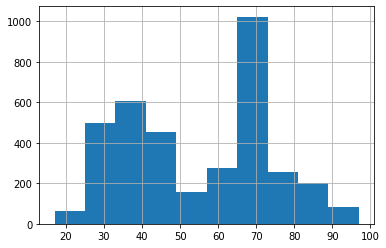

In [79]:
data[data["disease_info"]==0]["age"].hist()

In [102]:
ax = data_drop[data_drop["disease_info"]==0]["age"].hist(bins=10)# s is an instance of Series
fig = ax.get_figure()
fig.savefig('non_tb_age.pdf', figsize=(40, 40))

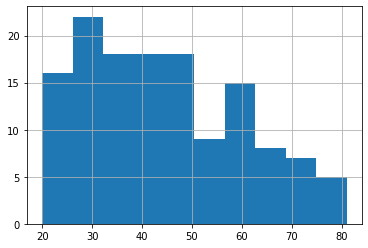

In [103]:
ax = data_drop[data_drop["disease_info"]==1]["age"].hist(bins=10)# s is an instance of Series
fig = ax.get_figure()
fig.savefig('tb_age.pdf', figsize=(40, 40))

In [105]:
data["LenECG"] = data["ECG_F"].apply(lambda x: len(x))

In [109]:
data[data["disease_info"]==1]["LenECG"].min()

48570

In [111]:
data[data["disease_info"]==1]["LenECG"].max()

300000

In [110]:
data[data["disease_info"]==0]["LenECG"].min()

30490

In [107]:
data["LenECG"].max()

300000

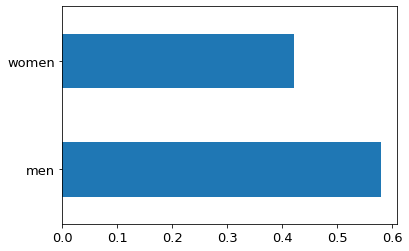

In [84]:
ax = data_drop[data_drop["disease_info"]==0]["gender_names"].value_counts(normalize=True).plot.barh(fontsize=13)# s is an instance of Series
fig = ax.get_figure()
fig.savefig('non_tb.pdf', figsize=(40, 40))

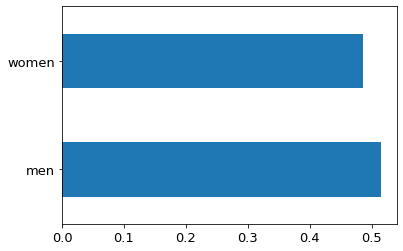

In [85]:
ax = data_drop[data_drop["disease_info"]==1]["gender_names"].value_counts(normalize=True).plot.barh(fontsize=13)# s is an instance of Series
fig = ax.get_figure()
fig.savefig('tb.pdf', figsize=(40, 40))

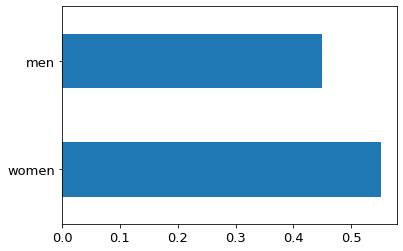

In [77]:
ax = data[data["disease_info"]==1]["gender_names"].value_counts(normalize=True).plot.barh(fontsize=13)# s is an instance of Series
fig = ax.get_figure()
fig.savefig('tb.pdf', figsize=(40, 40))

In [44]:
data[data["disease_info"]==1]["gender"].value_counts(normalize=True)

2    0.551136
1    0.448864
Name: gender, dtype: float64

In [114]:
train_p = np.load("train_p.npy")
test_p = np.load("test_p.npy")
val_p = np.load("val_p.npy")

In [115]:
len(train_p)

247

In [116]:
len(test_p)

144

In [117]:
len(val_p)

112

In [135]:
69 + 30 + 37

136

In [118]:
train = data[data["p_id"].isin(train_p)]
test = data[data["p_id"].isin(test_p)]
val = data[data["p_id"].isin(val_p)]

In [131]:
test["cardiogram_id"].nunique()

1130

In [132]:
test["p_id"].nunique()

144

In [133]:
test[test["disease_info"] == 1]["p_id"].nunique()

37

In [134]:
test[test["disease_info"] == 1]["cardiogram_id"].nunique()

288

In [127]:
val["cardiogram_id"].nunique()

1062

In [128]:
val["p_id"].nunique()

112

In [129]:
val[val["disease_info"] == 1]["p_id"].nunique()

30

In [130]:
val[val["disease_info"] == 1]["cardiogram_id"].nunique()

255

In [119]:
train[train["disease_info"] == 1]["p_id"].nunique()

69

In [125]:
train[train["disease_info"] == 1]["cardiogram_id"].nunique()

689

In [123]:
train.patient_id.nunique()

247

In [122]:
train.cardiogram_id.nunique()

2648

In [120]:
test[test["disease_info"] == 1]["p_id"].nunique()

37

In [121]:
val[val["disease_info"] == 1]["p_id"].nunique()

30

In [32]:
69+37+30

136